In [1]:
import numpy as np
import sympy as sp
from sympy import evalf,zeros,Matrix,plotting
import matplotlib.pyplot as plt
import sys
from scipy.integrate import quad
from scipy.special import eval_legendre,eval_hermitenorm,eval_chebyt
from tqdm import tqdm
sys.setrecursionlimit(20000)

In [2]:
def l(i,T,n):
    y = sp.Symbol('y')
    result = 1
    for k in range(n):
        if k != i:
            result = result*(y - T[i])/(T[i]-T[k])
    return result

In [3]:
def double_interp_series(matrix_A,pos,T,n):
    n_taylor_x = (K* l(pos[1],T,n)).subs(x,T[pos[0]])
    n_taylor_x_numpy = sp.lambdify(y,n_taylor_x,'numpy')
    n_result,_ = quad(n_taylor_x_numpy,begin,end)
    matrix_A[pos[0],pos[1]] = n_result
    return matrix_A

In [4]:
def construct_A(n,T):
    matrix_A = zeros(n)
    pos = []
    for p in range(0, n):
        for q in range(0, n):
            pos.append([p,q])
    for item in tqdm(pos):
        matrix_A = double_interp_series(matrix_A,item,T,n)
    Lambda_diag = Lambda*np.matrix(np.diag(np.ones(n)))
    return Lambda_diag - matrix_A

In [5]:
def loop(n):
    X = np.linspace(begin,end,n)
    if type == 'legendre':
        T = eval_legendre(degree,X)
    elif type == 'chebyshev':
        T = eval_chebyt(degree,X)
    elif type == 'equal_dist':
        T = X
    A_n = construct_A(n,T)
    y_ = sp.zeros(n,1)
    for i in tqdm(range(n)):
        g_mod = (g ).subs('y','x')
        g_mod_numpy = sp.lambdify(x,g_mod,'numpy')
        result,_ = quad(g_mod_numpy,begin,end)
        y_[i, 0] = result
    A_n_acce = np.matrix(A_n).astype(np.float64)
    A_n_acce_inv = A_n_acce**(-1)
    A_n_inv = Matrix(A_n_acce_inv)
    c = A_n_inv*y_
    result = 0
    for i in range(n):
        result = result + l(i,T,n)*c[i,0]
    f_result = (1/Lambda*(result+g)).subs('y','x')
    disp_val = []
    tol = 0
    x_begin = begin - tol
    x_end = end + tol
    x_list = np.arange(x_begin,x_end,(x_end-x_begin)/100)
    for i in tqdm(range(len(x_list))):
        disp_val.append(f_result.evalf(subs={'x':x_list[i]}))
    loss = sp.sqrt(np.sum((np.array(disp_val) - 1) ** 2) / n)
    return f_result,loss

## 主函数
本程序通过插值法构造退化核，插值点考虑legendre、hebyshev、等距插值，进而求解第二类Fredholm方程。
$$\lambda f(x) - \int_a^{b} k(x,y)f(y) dy = g(x)$$

In [6]:
x = sp.Symbol('x')   # 定义符号变量
y = sp.Symbol('y')

In [7]:
Lambda = 1
K = sp.exp(x*y)
begin = 0
end = 1
f_origin = 1+0*x
start = 20
total = 5
span = 2
type = 'legendre'   # equal_dist, chebyshev
# type = 'equal_dist'
#type = 'chebyshev'
degree = 30  # degree of polynomials

In [8]:
g = Lambda*f_origin-(K*f_origin.subs(x,y)).integrate((y,begin,end))
print(f"calculate g")
g

calculate g


1 - Piecewise((exp(x)/x - 1/x, (x > -oo) & (x < oo) & Ne(x, 0)), (1, True))

100%|██████████| 100/100 [00:04<00:00, 22.18it/s]


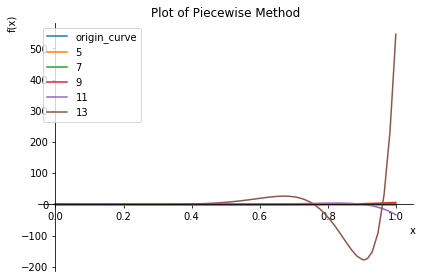

In [9]:
p = plotting.plot(1+0*x,(x,begin,end),show=False,label='origin_curve',legend=True,title='Plot of Piecewise Method')
err_list = []
for i in range(total,total+span*total,span):
    f_result,err = loop(i)
    err_list.append(float(err))
    p.append(plotting.plot(f_result,(x,begin,end) ,show=False,label=str(i))[0])
p.show()

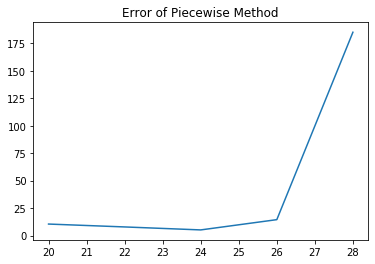

In [10]:
plt.plot(np.arange(start,start+total*span,span),err_list)
plt.title('Error of Piecewise Method')
plt.show()